<a href="https://colab.research.google.com/github/pach28/Forecasting-Sticker-Sales/blob/main/sticker_forecast_kaggle_stationary_treatment_%26_weighted_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

sns.set_style('whitegrid')

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
import os

# Download the competition dataset
playground_series_s5e1_path = kagglehub.competition_download('playground-series-s5e1')

# Extract the directory name from the downloaded path
dataset_dir = os.path.splitext(playground_series_s5e1_path)[0]

# Construct the correct paths to the train.csv and test.csv files
train_csv_path = os.path.join(dataset_dir, 'train.csv')
test_csv_path = os.path.join(dataset_dir, 'test.csv')

# Read the CSV files using the correct paths
train_df = pd.read_csv(train_csv_path, parse_dates=["date"])
test_df = pd.read_csv(test_csv_path, parse_dates=["date"])

In [ ]:
def get_gdp_per_capita(countries, start_year, end_year):
    # Construir la URL base de la API
    base_url = "https://api.worldbank.org/v2/country/"

    # Crear una lista de URLs para cada país
    urls = [f"{base_url}{country}/indicator/NY.GDP.PCAP.CD?date={start_year}:{end_year}&format=json" for country in countries]

    # Hacer las solicitudes a la API y crear un DataFrame para cada país
    dfs = []
    for url in urls:
        response = requests.get(url)
        data = response.json()

        # Check if the response is valid and contains data
        if response.status_code == 200 and len(data) > 1 and isinstance(data[1], list) and len(data[1]) > 0:
            df = pd.DataFrame(data[1])

            # Ensure 'country' and 'date' contain scalar values before pivoting
            # Example: If 'country' is a dictionary, extract a specific key
            if isinstance(df['country'].iloc[0], dict):
                df['country'] = df['country'].apply(lambda x: x['value'] if isinstance(x, dict) and 'value' in x else x)
            # Similarly, handle 'date' if necessary

            df = df.pivot_table(index='country', columns='date', values='value')
            dfs.append(df)
        else:
            print(f"Warning: Request for {url} failed or returned unexpected data.")

    # Concatenar los DataFrames
    df_final = pd.concat(dfs, axis=0)

    return df_final
countries = ['CAN', 'FIN', 'ITA','KEN','NOR','SGP']
df_pib = get_gdp_per_capita(countries, 2010, 2020)

In [ ]:
#sacar el ponderado de gdp por pais siendo por ano, el gdp del pais/ la suma de todos los paises
df_pib_ponderado = df_pib.div(df_pib.sum())
df_pib_ponderado

date,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
country,,,,,,,,,,,
Canada,0.178301,0.175045,0.178867,0.175479,0.173632,0.175439,0.171860,0.171772,0.164793,0.169793,0.169942
Finland,0.174349,0.171145,0.161484,0.165654,0.170609,0.171278,0.176478,0.175408,0.175823,0.177138,0.190594
Italy,0.135654,0.130223,0.119660,0.119171,0.121808,0.122289,0.126420,0.123907,0.123035,0.123858,0.125263
Kenya,0.004092,0.003674,0.004364,0.004570,0.005052,0.005993,0.006312,0.006347,0.006503,0.007181,0.007524
Norway,0.330517,0.339278,0.346987,0.345215,0.332766,0.301063,0.287829,0.289772,0.293166,0.279969,0.266753
Singapore,0.177087,0.180635,0.188638,0.189911,0.196132,0.223938,0.231100,0.232794,0.236680,0.242061,0.239924


identificar los NaN para tratarlos

In [ ]:
for country in train_df['country'].unique():
    for store in train_df[train_df['country'] == country]['store'].unique():
        for product in train_df[train_df['country'] == 'Canada']['product'].unique():
          x = train_df[(train_df['country'] == country) & (train_df['store'] == store) & (train_df['product'] == product)].isna().sum().sum()
          if x != 0:
              print(f"Pais: {country} Tienda: {store}, Producto: {product}, NaN: {x}")

Pais: Canada Tienda: Discount Stickers, Producto: Holographic Goose, NaN: 2557
Pais: Canada Tienda: Discount Stickers, Producto: Kerneler, NaN: 1
Pais: Canada Tienda: Stickers for Less, Producto: Holographic Goose, NaN: 1308
Pais: Canada Tienda: Premium Sticker Mart, Producto: Holographic Goose, NaN: 380
Pais: Kenya Tienda: Discount Stickers, Producto: Holographic Goose, NaN: 2557
Pais: Kenya Tienda: Discount Stickers, Producto: Kerneler, NaN: 63
Pais: Kenya Tienda: Discount Stickers, Producto: Kerneler Dark Mode, NaN: 1
Pais: Kenya Tienda: Stickers for Less, Producto: Holographic Goose, NaN: 1358
Pais: Kenya Tienda: Premium Sticker Mart, Producto: Holographic Goose, NaN: 646


Tratamiento de NaN

In [ ]:
train_df_imputed = train_df.copy()
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

train_df_imputed["year"] = train_df_imputed["date"].dt.year
for year in train_df_imputed["year"].unique():
    #Canada Discount Stickers Holographic Goose 2557 NaN (all)
    target_ratio = df_pib_ponderado.loc['Norway', str(year)] # Using Norway as should have the best precision
    current_raito = df_pib_ponderado.loc['Canada', str(year)]
    ratio_can = current_raito / target_ratio
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] * ratio_can).values

    #Canada Premium Sticker Mart Holographic Goose 380 NaN (missing values)
    current_ts =  train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_can).values

    #Canada Stickers for Less Holographic Goose 1308 NaN (missing values)
    current_ts =  train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_can).values

    #Kenya Discount Stickers Holographic Goose 2557 NaN (all)
    current_raito = df_pib_ponderado.loc['Kenya', str(year)]
    ratio_ken = current_raito / target_ratio
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Holographic Goose")& (train_df_imputed["year"] == year), "num_sold"] * ratio_ken).values

    #Kenya Premium Sticker Mart Holographic Goose 646 NaN (missing values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Premium Sticker Mart") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

    #Kenya Stickers for Less Holographic Goose 1358 NaN (missing values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Stickers for Less") & (train_df_imputed["product"] == "Holographic Goose") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

    #Kenya Discount Stickers Kerneler 63 NaN (missing values)
    current_ts = train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year)]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] = (train_df_imputed.loc[(train_df_imputed["country"] == "Norway") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & (train_df_imputed["year"] == year) & (train_df_imputed["date"].isin(missing_ts_dates)), "num_sold"] * ratio_ken).values

print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

Missing values remaining: 8871
Missing values remaining: 2


In [ ]:
missing = train_df_imputed.loc[train_df_imputed["num_sold"].isna()]
#dia y mes de missing
mes = missing["date"].dt.month
dia = missing["date"].dt.day

In [ ]:
missing

,id,date,country,store,product,num_sold,year
23719,23719,2010-09-21,Kenya,Discount Stickers,Kerneler Dark Mode,NaN,2010
207003,207003,2016-04-19,Canada,Discount Stickers,Kerneler,NaN,2016


In [ ]:
#recolectar la data de Kenya Discount Stickers Kerneler Dark Mode de dia y mes
train_df_imputed.loc[(train_df_imputed["country"] == "Kenya") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler Dark Mode") & train_df_imputed["date"].dt.month.isin([mes.iloc[0]]) & train_df_imputed["date"].dt.day.isin([dia.iloc[0]]),"num_sold"].mean()

7.333333333333333

In [ ]:
train_df_imputed.loc[(train_df_imputed["country"] == "Canada") & (train_df_imputed["store"] == "Discount Stickers") & (train_df_imputed["product"] == "Kerneler") & train_df_imputed["date"].dt.month.isin([mes.iloc[1]]) & train_df_imputed["date"].dt.day.isin([dia.iloc[1]]),"num_sold"].mean()

286.0

In [ ]:
train_df_imputed.loc[train_df_imputed["id"] == 23719, "num_sold"] = 7
train_df_imputed.loc[train_df_imputed["id"] == 207003, "num_sold"] = 286

In [ ]:
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

Missing values remaining: 0


In [ ]:
#train_df sera solo hasta antes de 2014 y test_df lo demas
test_df = train_df_imputed.loc[train_df_imputed["date"].dt.year >= 2014]
train_df_imputed = train_df_imputed.loc[train_df_imputed["date"].dt.year < 2014]

#store Weigths

In [ ]:
def decompose(train, c, ax):
    df = train.groupby(['date',c])[['num_sold']].sum().reset_index().join(
                            train.groupby('date')[['num_sold']].sum(), on='date',rsuffix='_global')
    df['fractions'] = df['num_sold']/df['num_sold_global']
    for m in np.sort(df[c].unique()):
        mask = df[c]==m
        ax.plot(df[mask]['date'],df[mask]['fractions'],label=m)
    ax.legend(bbox_to_anchor=(1, 1))

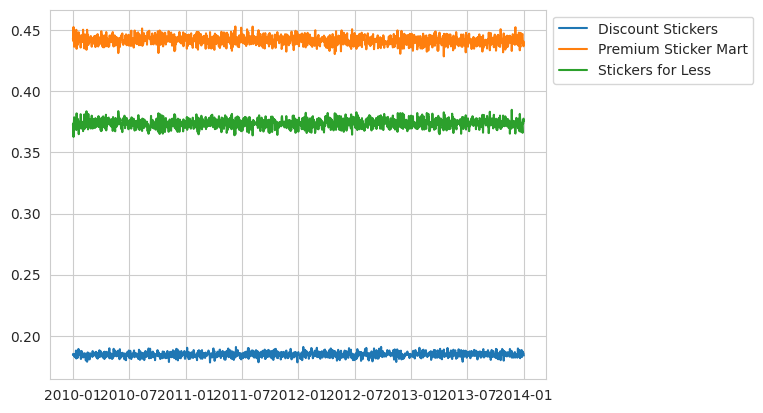

In [ ]:
_, ax = plt.subplots()
decompose(train_df_imputed, 'store', ax)
plt.show()

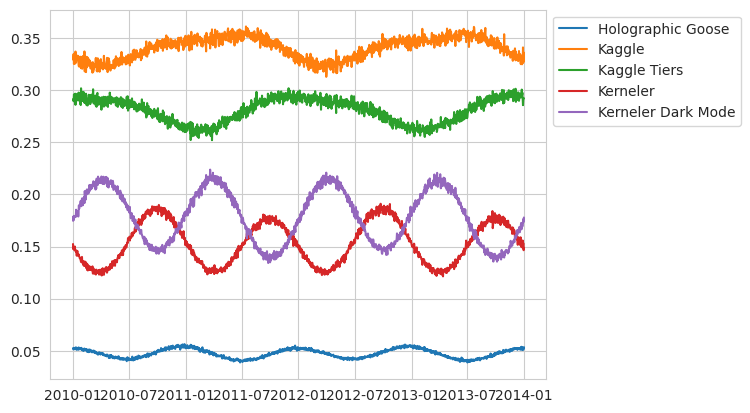

In [ ]:
_, ax = plt.subplots()
decompose(train_df_imputed, 'product', ax)
plt.show()

In [ ]:
#agrupar num_sold por stores
s_weight = train_df_imputed.groupby('store')['num_sold'].sum()/train_df_imputed['num_sold'].sum()

In [ ]:
#separar test_df["num_sold"] de test_df
test_df_num_sold = test_df["num_sold"]
test_df = test_df.drop(columns="num_sold")
#dropear year de test_df
test_df = test_df.drop(columns="year")

In [ ]:
product_df = train_df_imputed.groupby(["date","product"])["num_sold"].sum().reset_index()
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()


product_ratio_2014_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2010].copy()
product_ratio_2015_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2013].copy()
product_ratio_2016_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2012].copy()

product_ratio_2014_df["date"] = product_ratio_2014_df["date"] + pd.DateOffset(years=4)
product_ratio_2015_df["date"] = product_ratio_2015_df["date"] + pd.DateOffset(years=2)
product_ratio_2016_df["date"] =  product_ratio_2016_df["date"] + pd.DateOffset(years=4)

forecasted_ratios_df = pd.concat([product_ratio_2014_df, product_ratio_2015_df, product_ratio_2016_df])

forecasted_ratios_df.head(5)

,date,product,ratios
0,2014-01-01,Holographic Goose,0.052433
1,2014-01-01,Kaggle,0.329308
2,2014-01-01,Kaggle Tiers,0.291168
3,2014-01-01,Kerneler,0.152374
4,2014-01-01,Kerneler Dark Mode,0.174717


In [ ]:
original_train_df = train_df_imputed.copy()
train_df_imputed = train_df_imputed.groupby(["date"])["num_sold"].sum().reset_index()

In [ ]:
train_df_imputed["year"] = train_df_imputed["date"].dt.year
train_df_imputed["month"] = train_df_imputed["date"].dt.month
train_df_imputed["day"] = train_df_imputed["date"].dt.day
train_df_imputed["day_of_week"] = train_df_imputed["date"].dt.dayofweek

obteniendo las fechas de test

In [ ]:
test_total_sales_df = test_df.groupby(["date"])["id"].first().reset_index().drop(columns="id")
test_total_sales_df["month"] = test_total_sales_df["date"].dt.month
test_total_sales_df["day"] = test_total_sales_df["date"].dt.day
test_total_sales_df["day_of_week"] = test_total_sales_df["date"].dt.day_of_week

In [ ]:
day_of_week_ratio = (train_df_imputed.groupby("day_of_week")["num_sold"].mean() / train_df_imputed.groupby("day_of_week")["num_sold"].mean().mean()).rename("day_of_week_ratios")
display(day_of_week_ratio)
train_df_imputed = pd.merge(train_df_imputed, day_of_week_ratio, how="left", on="day_of_week")
train_df_imputed["adjusted_num_sold"] = train_df_imputed["num_sold"] / train_df_imputed["day_of_week_ratios"]

,day_of_week_ratios
day_of_week,
0,0.943323
1,0.942591
2,0.942005
3,0.942962
4,1.001049
5,1.057751
6,1.170318


In [ ]:
train_last_x_years_df = train_df_imputed.loc[train_df_imputed["year"] >= 2010]
train_day_mean_df = train_last_x_years_df.groupby(["month", "day"])["adjusted_num_sold"].mean().reset_index()

In [ ]:
test_total_sales_df = pd.merge(test_total_sales_df, train_day_mean_df, how="left", on=["month", "day"])
test_total_sales_df = pd.merge(test_total_sales_df, day_of_week_ratio.reset_index(), how="left", on="day_of_week")
test_total_sales_df["num_sold"] = test_total_sales_df["adjusted_num_sold"] * test_total_sales_df["day_of_week_ratios"]

In [ ]:
# Adding in the store ratios
store_weights_df = s_weight.reset_index()
test_sub_df = pd.merge(test_df, test_total_sales_df, how="left", on="date")
test_sub_df = test_sub_df.rename(columns = {"num_sold":"day_num_sold"})

In [ ]:
# Adding in the product ratios
test_sub_df = pd.merge(test_sub_df, store_weights_df, how="left", on="store")
test_sub_df = test_sub_df.rename(columns = {"num_sold":"store_ratio"})

In [ ]:
#ordenar por filas el df_pib_ponderado
df_melted = pd.melt(df_pib_ponderado.reset_index(), id_vars='country', var_name='year', value_name='value') # Reset the index to make 'country' a column
df_melted = df_melted.sort_values(by=['country', 'year'])
df_melted = df_melted.reset_index(drop=True)
#covetir year en formato
df_melted["year"] = df_melted["year"].astype(int)

In [ ]:
# Adding in the country ratios
test_sub_df["year"] = test_sub_df["date"].dt.year
test_sub_df = pd.merge(test_sub_df, df_melted, how="left", on=["year", "country"])
test_sub_df = test_sub_df.rename(columns = {"value":"country_ratio"})

In [ ]:
# Adding in the product ratio
test_sub_df = pd.merge(test_sub_df, forecasted_ratios_df, how="left", on=["date", "product"])
test_sub_df = test_sub_df.rename(columns = {"ratios":"product_ratio"})

In [ ]:
# Disaggregating the forecast
test_sub_df["num_sold"] = test_sub_df["day_num_sold"] * test_sub_df["store_ratio"] * test_sub_df["country_ratio"] * test_sub_df["product_ratio"]
test_sub_df["num_sold"] = test_sub_df["num_sold"].round()

In [ ]:
test_sub_df

,id,date,country,store,product,month,day,day_of_week,adjusted_num_sold,day_of_week_ratios,day_num_sold,store_ratio,year,country_ratio,product_ratio,num_sold
0,131490,2014-01-01,Canada,Discount Stickers,Holographic Goose,1,1,2,83300.203877,0.942005,78469.216419,0.184657,2014,0.173632,0.052433,132.0
1,131491,2014-01-01,Canada,Discount Stickers,Kaggle,1,1,2,83300.203877,0.942005,78469.216419,0.184657,2014,0.173632,0.329308,829.0
2,131492,2014-01-01,Canada,Discount Stickers,Kaggle Tiers,1,1,2,83300.203877,0.942005,78469.216419,0.184657,2014,0.173632,0.291168,733.0
3,131493,2014-01-01,Canada,Discount Stickers,Kerneler,1,1,2,83300.203877,0.942005,78469.216419,0.184657,2014,0.173632,0.152374,383.0
4,131494,2014-01-01,Canada,Discount Stickers,Kerneler Dark Mode,1,1,2,83300.203877,0.942005,78469.216419,0.184657,2014,0.173632,0.174717,440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98635,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,12,31,5,87172.448896,1.057751,92206.774335,0.441658,2016,0.231100,0.053584,504.0
98636,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,12,31,5,87172.448896,1.057751,92206.774335,0.441658,2016,0.231100,0.345452,3251.0
98637,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,12,31,5,87172.448896,1.057751,92206.774335,0.441658,2016,0.231100,0.263231,2477.0
98638,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,12,31,5,87172.448896,1.057751,92206.774335,0.441658,2016,0.231100,0.153616,1446.0


In [ ]:
submission = test_df['id'].to_frame()
submission['num_sold'] = test_sub_df['num_sold'].values

In [ ]:
submission

,id,num_sold
131490,131490,132.0
131491,131491,829.0
131492,131492,733.0
131493,131493,383.0
131494,131494,440.0
...,...,...
230125,230125,504.0
230126,230126,3251.0
230127,230127,2477.0
230128,230128,1446.0


In [ ]:
#medir el mape entre test_df_num_sold y submission["num_sold"]
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test_df_num_sold, submission["num_sold"])

0.12990867921617938

In [ ]:
submission.to_csv('forecast_2014-2016.csv', index=False)

#Haremos lo mismo para 2014, 2015 y 2016 con objetivo de tener un modelo de ml que entrene con esos años y mejore las predicciones de 2017,2018 y 2019